<a href="https://colab.research.google.com/github/coronarita1991/AIFFEL_RESEARCH_STUDY/blob/main/Ablation_Study_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[]

In [ ]:
import urllib3
urllib3.disable_warnings()

 # 데이터셋 다운로드의 프로그레스 바가 나타나지 않게 합니다.
# tfds.disable_progress_bar()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.7WYJFF_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.7WYJFF_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow dataset에 대한 feature 확인
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [ ]:
# 데이터 수 확인 - numpy가 아니기 때문에, .shape 호출은 불가능
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [ ]:
# 정규화 진행
def normalize_and_resize_img(image, label, size):
    """Normalizes images: `uint8` -> `float32`."""

    # Resize
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [size, size])

    # Normalize
    image /= 255.0

    return image, label

In [ ]:
print(type(ds_train))
print(type(ds_test))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, img_size=32):
    # apply normalize
    ds = ds.map(
        lambda x, y: normalize_and_resize_img(x, y, img_size),
        num_parallel_calls=1
    )
    # make batch
    ds = ds.batch(batch_size)

    if not is_test:
        ds = ds.repeat() # 정확하게 이해하지는 못했음. 아마 매학습마다 반복을 해주는데
        ds = ds.shuffle(200) # shuffle을 두어서 미리 담아둘수 있는 공간을 확보

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # 미리 최적 배치들을 준비하게 함

    return ds

In [ ]:
ds_info.features['label'].num_classes

10

In [ ]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

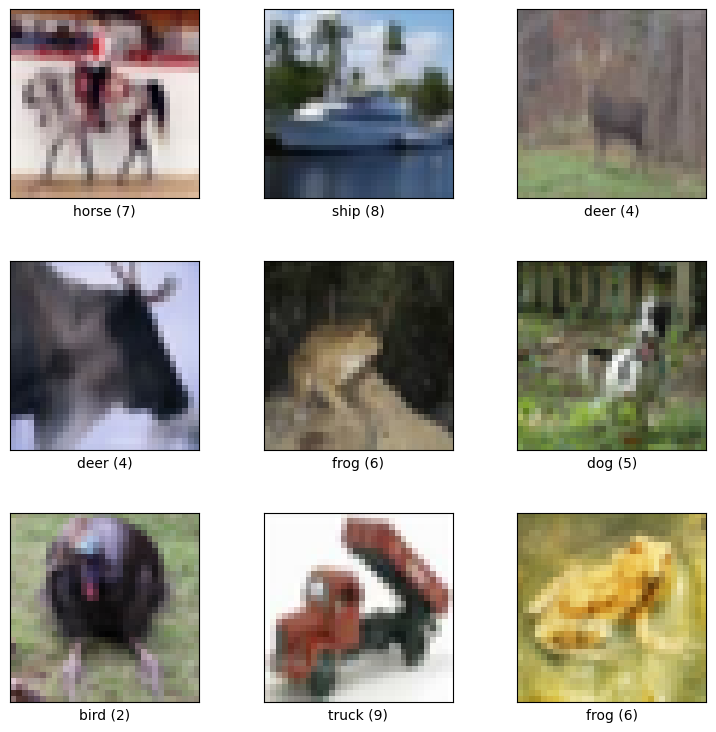

In [ ]:
# 데이터 예시 보기
fig = tfds.show_examples(ds_train, ds_info)

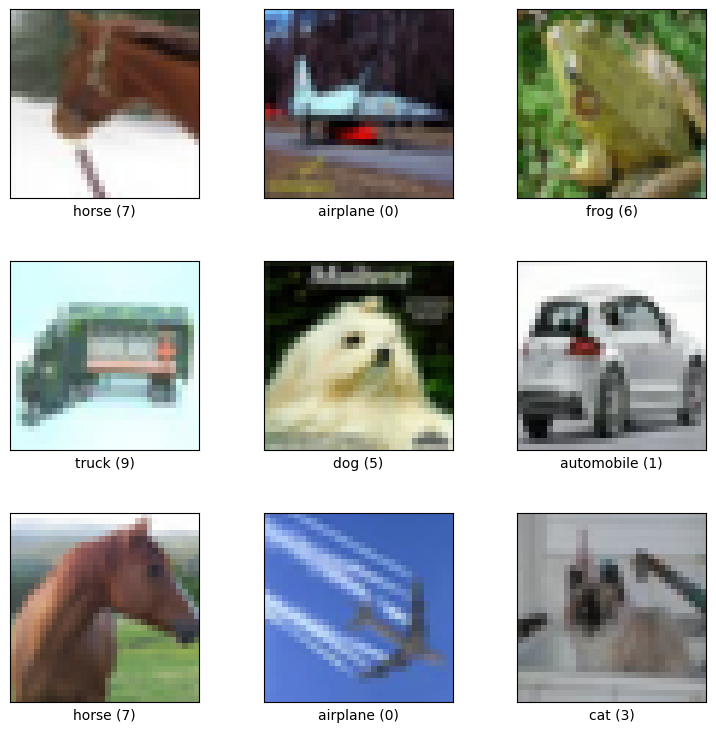

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

# VGG 기본 블록 만들기

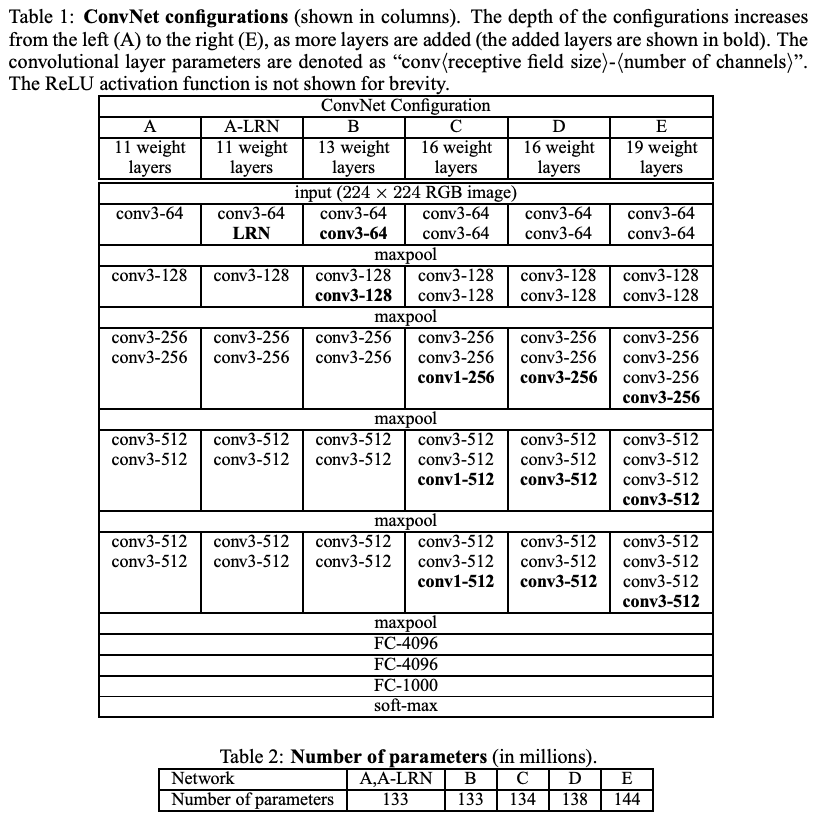

In [ ]:
# Func for VGG
def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,
                    ):
    # Input
    x = input_layer

    # Convolution
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            activation='relu',
            kernel_initializer='he_normal', #
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)

    # Max Pooling
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        name=f'block{block_num}_pooling'
    )(x)

    return x


VGG 블록을 추가하는 함수로 input_layer에 추가 - (32, 32, 3)의 형태
- 이를 입력 인자로 받아 build_vgg_block() 호출

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32, 32, 3)) # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer) # vgg block 생성

In [ ]:
# 블록 1개짜리 모델
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling  (None, 16, 16, 64)        0         
 2D)                                                             
                                                                 
Total params: 75648 (295.50 KB)
Trainable params: 75648 (295.50 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

# VGG16

In [ ]:
# VGG 생성하는 함수

def build_vgg(input_shape=(32, 32, 3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              # num_cnn_list, channel_list config list으로 추정
              num_classes=10):

    assert len(num_cnn_list) == len(channel_list) # 모델 생성 전 일치 여부를 체크

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i
        )

    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',
                                name='predictions')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output
        )

    return model



In [ ]:
# VGG-16을 만듭니다.
vgg_16 = build_vgg()
vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling  (None, 16, 16, 64)        0         
 2D)                                                             
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

# VGG19

In [ ]:
vgg_19 = build_vgg(input_shape=(32, 32, 3),
              num_cnn_list=[2,2,4,4,4],
              channel_list=[64,128,256,512,512],
              num_classes=10)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling  (None, 16, 16, 64)        0         
 2D)                                                             
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

# VGG13

In [ ]:
vgg_13 = build_vgg(input_shape=(32, 32, 3),
              num_cnn_list=[2,2,2,2,2],
              channel_list=[64,128,256,512,512],
              num_classes=10)

vgg_13.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling  (None, 16, 16, 64)        0         
 2D)                                                             
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

# VGG16 vs VGG19 with using CIFAR-10 Datasets

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# Make VGG-16 model and train !

In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=1e-2,
                                     clipnorm=1.),
    # clipnorm - gradient vanishing을 막기 위해 일정값이 상의 Gradient를 잘라내는 트릭
    # https://ddggblog.tistory.com/179
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/15
  1/195 [..............................] - ETA: 2:38:48 - loss: 2.2994

KeyboardInterrupt: 

# Make VGG-19 model and Train !

In [ ]:
# Re-allocate if you want to change
BATCH_SIZE = 256
EPOCH = 15

In [ ]:

vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=1e-2,
                                     clipnorm=1.),
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

# Make plot and Compare VGG16 and VGG19 !

## For Loss

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

## For Accuracy

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()